# Plotting extra charts for model outcomes per city

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.lines as mlines
import util
from model.sirds_model_visualization import get_sirds, get_sirds_extras, plot_result_simple, show_performance, \
    plot_result, plot_parameters

## Loading data

In [2]:
df_results_municipalites = pd.read_csv('../data/execution_results.csv')

In [3]:
df = pd.read_csv('../data/df_ts_epidemic_episodes.csv', index_col=0)
df.DATA = pd.to_datetime(df.DATA)
df['TAXA_CASOS_NOVOS_MEDIA_MOVEL_7_DIAS'] = df['CASOS_NOVOS_MEDIA_MOVEL_7_DIAS'] / df['POPULACAO_2022']  * 100000
df['MUNICIPIO_UF'] = df['MUNICIPIO'] + '/' + df['SIGLA_ESTADO']
df = df.sort_values(by=['MUNICIPIO_UF','DATA'])

## Plotting

In [4]:
plt.rc('font', size=8)
sns.set_style("ticks")

Aparecida de Goiânia
mae_fit :  0.30647009327008773 ( 0.29582290548962303 , 0.31702207723541026 )
sse_D_fit :  0.015667876286246548 ( 0.014006169876879948 , 0.01741659710154874 )
r2_D_fit :  0.9309545870051131 ( 0.9238070005273437 , 0.9380394274184853 )
sse_Rt_fit :  0.015549129748873578 ( 0.014106859639471465 , 0.01680105796226839 )
r2_Rt_fit :  0.3821369133853918 ( 0.33198624359938467 , 0.43297299132526024 )


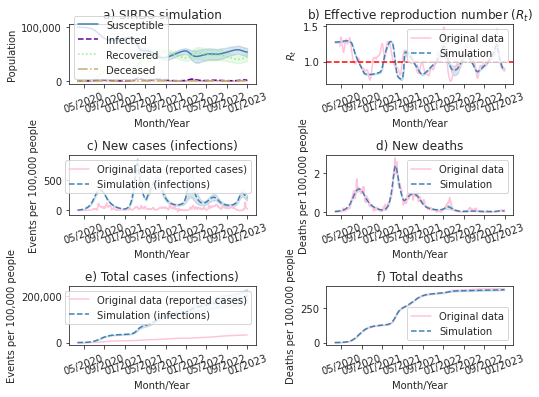

In [ ]:
from model.sirds_model_visualization import calculate_performance

days_to_recovery = 8
for municipality in df_results_municipalites.municipality.unique():
    print(municipality)
    df_results = df_results_municipalites[df_results_municipalites.municipality == municipality]
    date_first_case = pd.to_datetime(df_results.date_first_case.unique()[0])
    
    df_covid_municipality = df[(df.MUNICIPIO == municipality) & (df.DATA >= date_first_case)]
    real_reproduction_number = df_covid_municipality.NUMERO_REPRODUCAO_EFETIVO_SRAG_MEDIA.values
    real_new_deaths = df_covid_municipality.TAXA_OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS.values
    real_total_deaths = df_covid_municipality.TAXA_OBITOS_NOVOS_MEDIA_MOVEL_7_DIAS.cumsum().values
    real_new_cases = df_covid_municipality.TAXA_CASOS_NOVOS_MEDIA_MOVEL_7_DIAS.values
    real_total_cases = df_covid_municipality.TAXA_CASOS_NOVOS_MEDIA_MOVEL_7_DIAS.cumsum().values
        
    df_S = pd.DataFrame()
    df_I = pd.DataFrame()
    df_R = pd.DataFrame()
    df_D = pd.DataFrame()
    df_I_accumulated = pd.DataFrame()
    df_new_deaths = pd.DataFrame()
    df_rt = pd.DataFrame()
    df_new_cases = pd.DataFrame()
    df_r0 = pd.DataFrame()
    df_IFR = pd.DataFrame()
    df_Omega = pd.DataFrame()
    list_fuzzy_fast_transition = []
    list_fuzzy_slow_transition = []
    
    dict_performance = {'mae_fit': [], 'sse_D_fit': [], 'r2_D_fit': [], 'sse_Rt_fit': [], 'r2_Rt_fit': []}
    
    for index, result in df_results.iterrows():            
        result = result.dropna()
        
        y = get_sirds(result)
        S, I, R, D, I_accumulated = y
        min_length = min(len(real_new_deaths), len(D))
        S = S[:min_length]
        I = I[:min_length]
        R = R[:min_length]
        D = D[:min_length]
        I_accumulated = I_accumulated[:min_length]
        N = S[0] + I[0] + R[0] + D[0]
        
        dates = df_covid_municipality[:min_length].DATA.values
        
        D_new_deaths, reproduction_number_sird, I_new_cases, epidemic_periods_with_fast_transition_fuzzy_variable, epidemic_periods_with_slow_transition_fuzzy_variable, days_between_infections_values, case_fatality_probability_values, loss_immunity_in_days_values, estimated_days_between_infections, estimated_case_fatality_probability, estimated_loss_immunity_in_days = get_sirds_extras(result, S, D, I_accumulated)
        
        df_S_temp = pd.DataFrame({'date': dates, 'S': S})
        df_I_temp = pd.DataFrame({'date': dates, 'I': I})
        df_R_temp = pd.DataFrame({'date': dates, 'R': R})
        df_D_temp = pd.DataFrame({'date': dates, 'D': D})
        df_I_accumulated_temp = pd.DataFrame({'date': dates, 'I_accumulated': I_accumulated})
        df_new_deaths_temp = pd.DataFrame({'date': dates[1:], 'deaths': D_new_deaths})
        df_rt_temp = pd.DataFrame({'date': dates, 'rt': reproduction_number_sird})
        df_new_cases_temp = pd.DataFrame({'date': dates[1:], 'cases': I_new_cases})
        df_r0_temp = pd.DataFrame({'date': dates, 'r0': days_to_recovery/estimated_days_between_infections}) 
        df_IRF_temp = pd.DataFrame({'date': dates, 'ifr': estimated_case_fatality_probability})
        df_Omega_temp = pd.DataFrame({'date': dates, 'Omega': estimated_loss_immunity_in_days})
                   
        df_S = pd.concat([df_S, df_S_temp])
        df_I = pd.concat([df_I, df_I_temp])
        df_R = pd.concat([df_R, df_R_temp])
        df_D = pd.concat([df_D, df_D_temp])
        df_I_accumulated = pd.concat([df_I_accumulated, df_I_accumulated_temp])
        df_new_deaths = pd.concat([df_new_deaths, df_new_deaths_temp])
        df_rt = pd.concat([df_rt, df_rt_temp])
        df_new_cases = pd.concat([df_new_cases, df_new_cases_temp])
        df_r0 = pd.concat([df_r0, df_r0_temp])
        df_IFR = pd.concat([df_IFR, df_IRF_temp])
        df_Omega = pd.concat([df_Omega, df_Omega_temp])
        list_fuzzy_fast_transition.append(epidemic_periods_with_fast_transition_fuzzy_variable)
        list_fuzzy_slow_transition.append(epidemic_periods_with_slow_transition_fuzzy_variable)
        
        mae_fit, sse_D_fit, r2_D_fit, sse_Rt_fit, r2_Rt_fit = calculate_performance(real_new_deaths, D_new_deaths, real_reproduction_number,  reproduction_number_sird)
        dict_performance['mae_fit'].append(mae_fit)
        dict_performance['sse_D_fit'].append(sse_D_fit)
        dict_performance['r2_D_fit'].append(r2_D_fit)
        dict_performance['sse_Rt_fit'].append(sse_Rt_fit)
        dict_performance['r2_Rt_fit'].append(r2_Rt_fit)

    show_performance(dict_performance)
           
    plot_result(df_S, df_I, df_R, df_D, df_new_deaths, df_I_accumulated, real_new_deaths[:min_length], real_total_deaths[:min_length], real_reproduction_number[:min_length], df_rt, real_total_cases[:min_length], real_new_cases[:min_length], df_new_cases, df_covid_municipality[:min_length].DATA.values, id_in_file=municipality)

    plot_parameters(df_r0, df_IFR, df_Omega, municipality)